In [397]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import Birch
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

from IPython.core import display


%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.set_option('display.max_columns', None)
plt.style.use('seaborn')
fname = "nutrition.csv"
scatter_pt_size = 2

## Data Cleaning
Convert "Income" column data to numerical.

In [409]:
data = pd.read_csv(fname, usecols=['Data_Value','Income','Sample_Size'])
data = data.dropna()

print("size of the data: ", len(data))
data.head(10)

size of the data:  13349


,Data_Value,Sample_Size,Income
13,38.5,1112.0,"Less than $15,000"
14,34.8,1367.0,"$15,000 - $24,999"
15,35.8,757.0,"$25,000 - $34,999"
16,32.3,861.0,"$35,000 - $49,999"
17,34.1,785.0,"$50,000 - $74,999"
18,28.8,1125.0,"$75,000 or greater"
19,23.8,1297.0,Data not reported
41,28.4,1112.0,"Less than $15,000"
42,31.9,1367.0,"$15,000 - $24,999"
43,35.7,757.0,"$25,000 - $34,999"


In [410]:
data['Income'] = data['Income'].str.split('-').str[0]
data['Income'] = data['Income'].str.replace(r'[^0-9]+', '', regex=True)
data['Income'] = data['Income'].replace("", float("NaN")).astype('float')
data = data.dropna()

data.head(10)

,Data_Value,Sample_Size,Income
13,38.5,1112.0,15000.0
14,34.8,1367.0,15000.0
15,35.8,757.0,25000.0
16,32.3,861.0,35000.0
17,34.1,785.0,50000.0
18,28.8,1125.0,75000.0
41,28.4,1112.0,15000.0
42,31.9,1367.0,15000.0
43,35.7,757.0,25000.0
44,36.6,861.0,35000.0


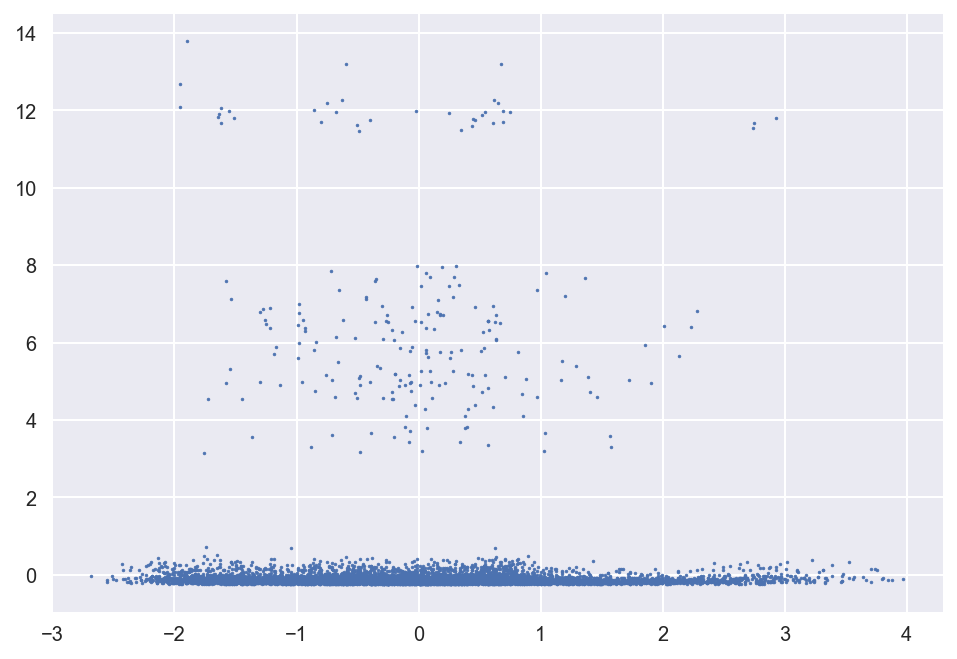

In [414]:
X_pretrain = pd.DataFrame(data['Data_Value'])
Y_pretrain = pd.DataFrame(data['Sample_Size'])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_pretrain)
Y_train = scaler.fit_transform(Y_pretrain)

plt.scatter(X_train, Y_train, s=scatter_pt_size)
plt.show()

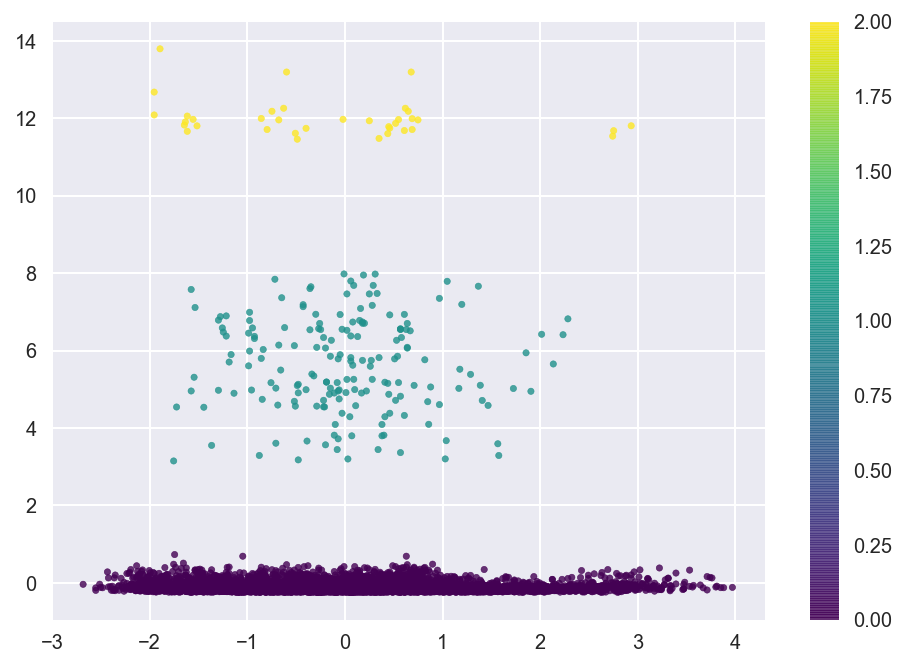

In [415]:
train_data = pd.DataFrame({'Data_Value':X_train[:,0], 'Sample_Size':Y_train[:,0]})

#gmm = BayesianGaussianMixture(n_components=3, init_params="random", random_state=42, n_init=10, \
#                              covariance_type="diag", max_iter=1000)
cluster = Birch(threshold=0.1, n_clusters=3)
cluster_classes = cluster.fit_predict(train_data)
plt.scatter(train_data['Data_Value'], train_data['Sample_Size'], c=cluster_classes, s=5*scatter_pt_size, alpha=0.8, cmap= 'viridis')
plt.colorbar()
plt.show()

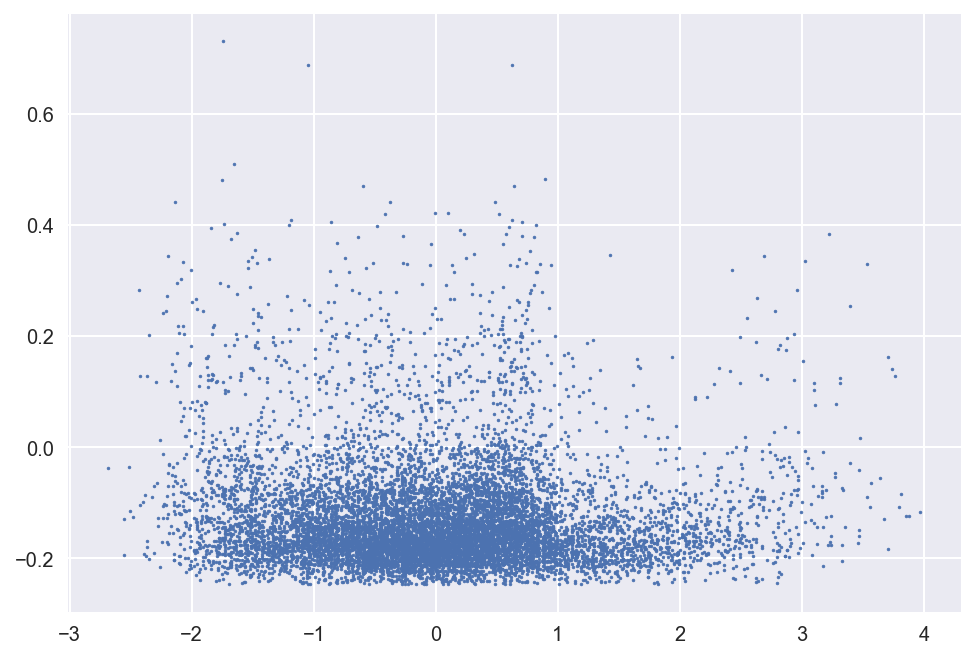

In [416]:
train_data = train_data.iloc[cluster_classes==0]
plt.scatter(train_data['Data_Value'], train_data['Sample_Size'], s=scatter_pt_size)
plt.show()

## Monomial Features

Fit a linear model using sklearning

r_sq: 0.0022617686190394837
intercept: [1.27792828e-16]
slope: [[-0.04755806]]


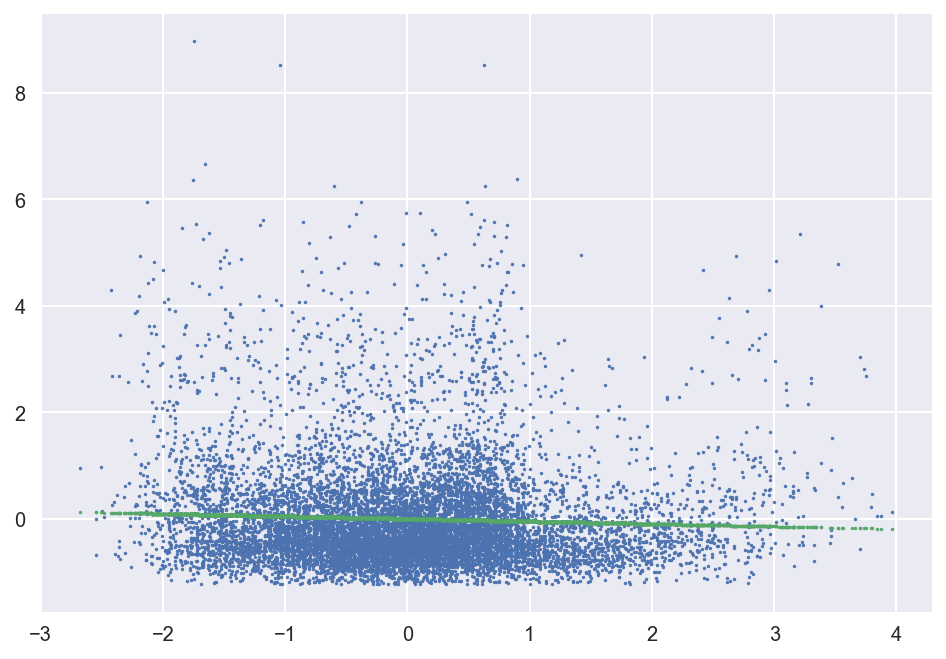

In [417]:
model = LinearRegression()
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(pd.DataFrame(train_data['Data_Value'])))
Y_train = pd.DataFrame(scaler.fit_transform(pd.DataFrame(train_data['Sample_Size'])))
model.fit(X_train, Y_train)
r_sq = model.score(X_train, Y_train)
print('r_sq:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

Y_pred = model.predict(X_train)
plt.scatter(X_train, Y_train, s=scatter_pt_size)
plt.scatter(X_train, Y_pred, s=scatter_pt_size)
plt.show()

Fit the same linear model with "statsmodels". Using KFold to divide the data to 2-fold, 50-50 divided train set and test set. Showing summary which includes $R^2$ and parameter's t-statistics. An $R^2$ close to 1 indicates a good fitting, close to 0 indicates a useless one. $-2 < t < 2$ means that the corresponding parameter is not significantly different from 0. It may be a redundant parameter.

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              29.71
Date:                Thu, 11 Feb 2021   Prob (F-statistic):                    5.23e-08
Time:                        22:09:11   Log-Likelihood:                         -7854.6
No. Observations:                5613   AIC:                                  1.571e+04
Df Residuals:                    5612   BIC:                                  1.572e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

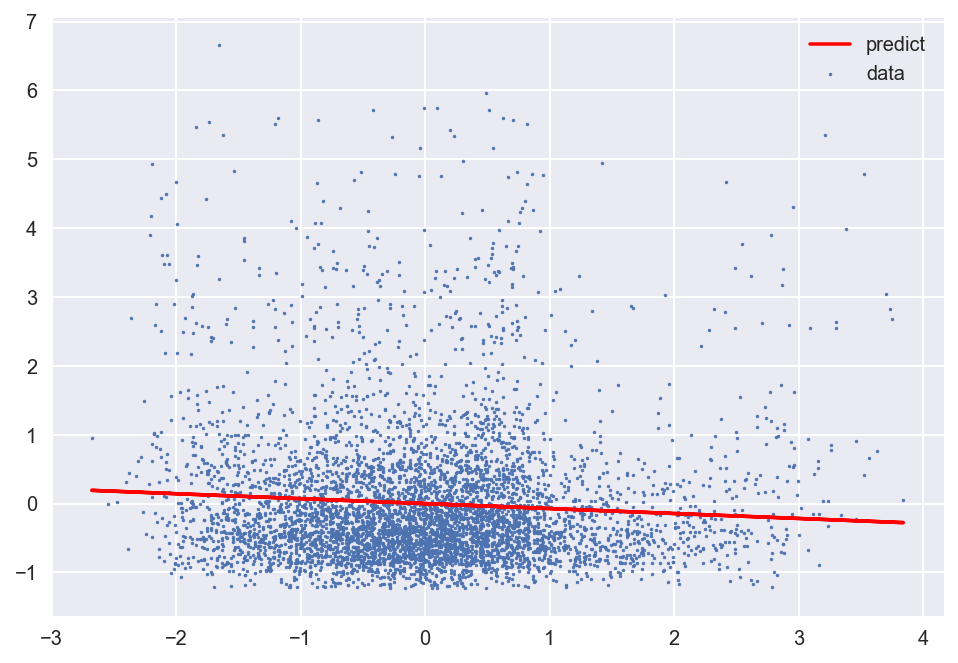

In [418]:
kf = KFold(n_splits=2, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X_train):
    # just take the first train-test partition as an example
    break
    
model = sm.OLS(Y_train.iloc[train_index], X_train.iloc[train_index])
results = model.fit()
print(results.summary())
Y_predict = results.predict(X_train.iloc[test_index])
plt.plot(X_train.iloc[test_index,0], Y_predict, label='predict', color='r')
plt.scatter(X_train.iloc[test_index,0], Y_train.iloc[test_index,0], s=scatter_pt_size, label='data')
plt.legend(); plt.show()

__Residual vs Fit plot:__ Check for linearity and homoscedasticity (even variance) of the fit. Large standardized residues (|res| > 2) indicates deviation from linear assumption. Patterns of residuals away from y = 2 means violation of homoscedasticity.

__Quantile-Quantile plot:__ Check for normality (data is normally distributed) of residuals. Check if the residual quantiles distribute like normal distribution's quantile. Significant diviation from 45 degree line indicates fail of normality on the residuals.

__Scale-Location plot:__ Check for patterns, which violate homoscedasticity.

__Cook's Distance:__ Check for influential outliers. Showing each data point influences on the fitting parameters. Cook's distances of $\gtrsim$ 1 in indicates individual data points have too much influence over the whole fitting.

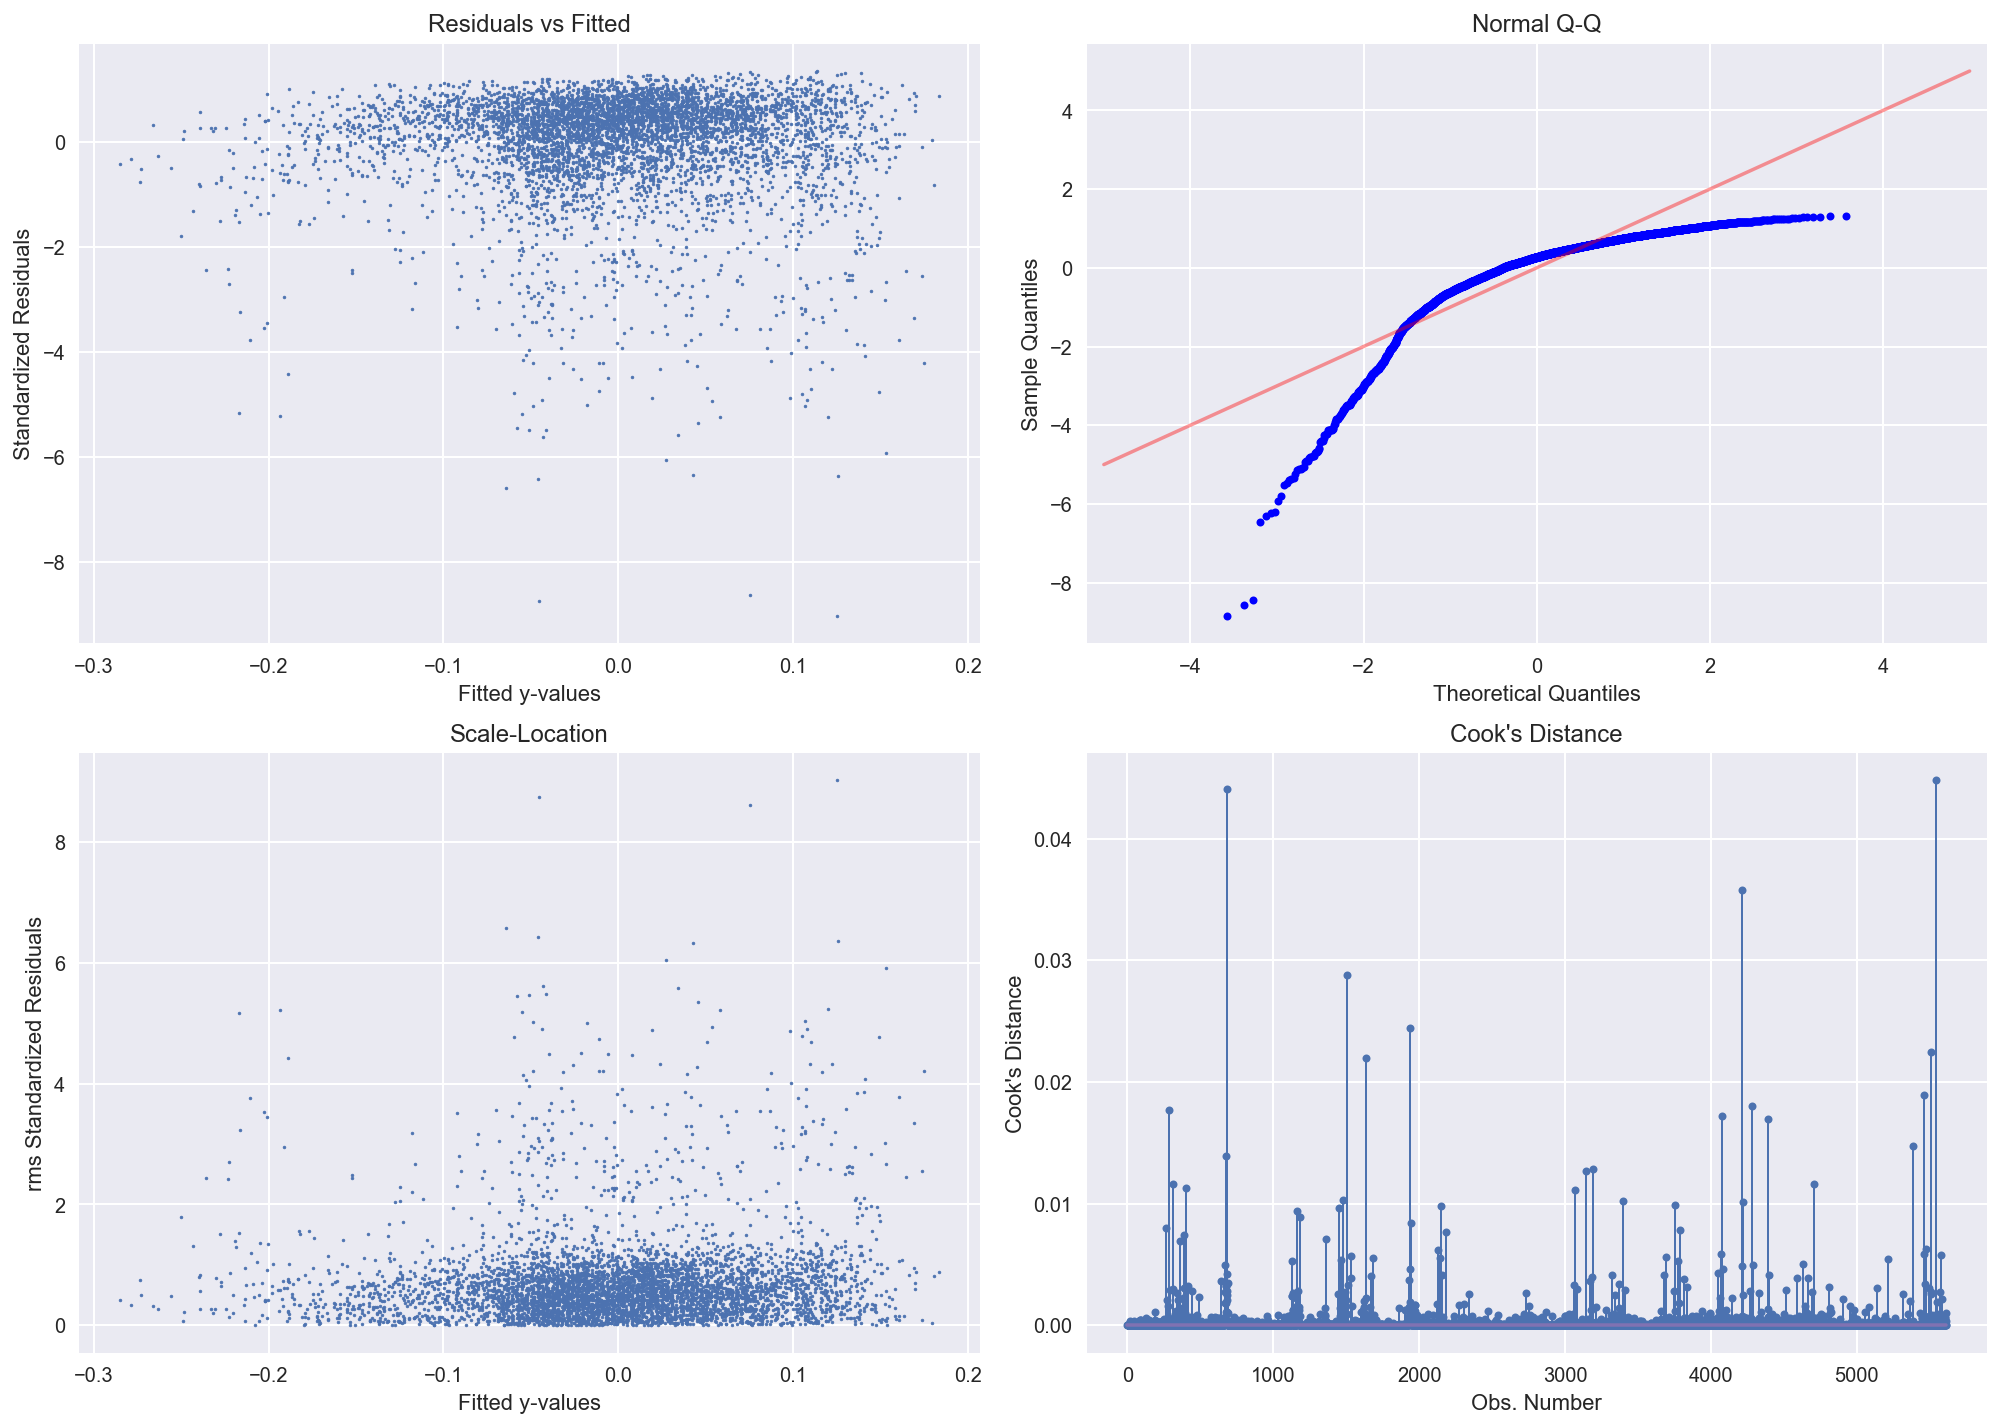

In [420]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
Y_predict = results.predict(X_train.iloc[train_index])
mse = mean_squared_error(Y_predict, Y_train.iloc[train_index,0])

ax[0,0].scatter(Y_predict, (Y_predict - Y_train.iloc[train_index,0])/np.sqrt(mse), s=scatter_pt_size)
ax[0,0].set_xlabel('Fitted y-values')
ax[0,0].set_ylabel('Standardized Residuals')
ax[0,0].set_title('Residuals vs Fitted')

qqplot(Y_predict - Y_train.iloc[train_index,0], stats.t, distargs=(len(Y_predict)-1,), ax=ax[0,1], markersize=2*scatter_pt_size)
ax[0,1].plot([-5,5],[-5,5], color='r', alpha=0.4)
ax[0,1].set_title('Normal Q-Q')

st_res = np.sqrt((Y_predict - Y_train.iloc[train_index,0])**2/mse)
ax[1,0].scatter(Y_predict,st_res, s=scatter_pt_size)
ax[1,0].set_title('Scale-Location')
ax[1,0].set_xlabel('Fitted y-values')
ax[1,0].set_ylabel('rms Standardized Residuals')

influence = results.get_influence()
cooks, cooks_p = influence.cooks_distance
markers, stemlines, baseline = ax[1,1].stem(np.arange(len(X_train.iloc[train_index,0])), cooks)
plt.setp(stemlines, linewidth=scatter_pt_size/2.)
plt.setp(markers, markersize=2*scatter_pt_size)
ax[1,1].set_title('Cook\'s Distance')
ax[1,1].set_xlabel('Obs. Number')
ax[1,1].set_ylabel('Cook\'s Distance')

plt.tight_layout()
plt.show()

## Polynomial Features

Fitting with a polynomial model:  $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$.

In [316]:
transformer = PolynomialFeatures(degree=3, include_bias=False)
X_train = scaler.fit_transform(pd.DataFrame(train_data['Data_Value']))
Y_train = scaler.fit_transform(pd.DataFrame(train_data['Sample_Size']))
X3_train = transformer.fit_transform(X_train)
model = LinearRegression().fit(X3_train, Y_train)
model.fit(X3_train, Y_train)
r_sq = model.score(X3_train, Y_train)
print('r_sq:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

r_sq: 0.016012385460386858
intercept: [-0.0823936]
slope: [[-0.05122847  0.08593578 -0.00860825]]


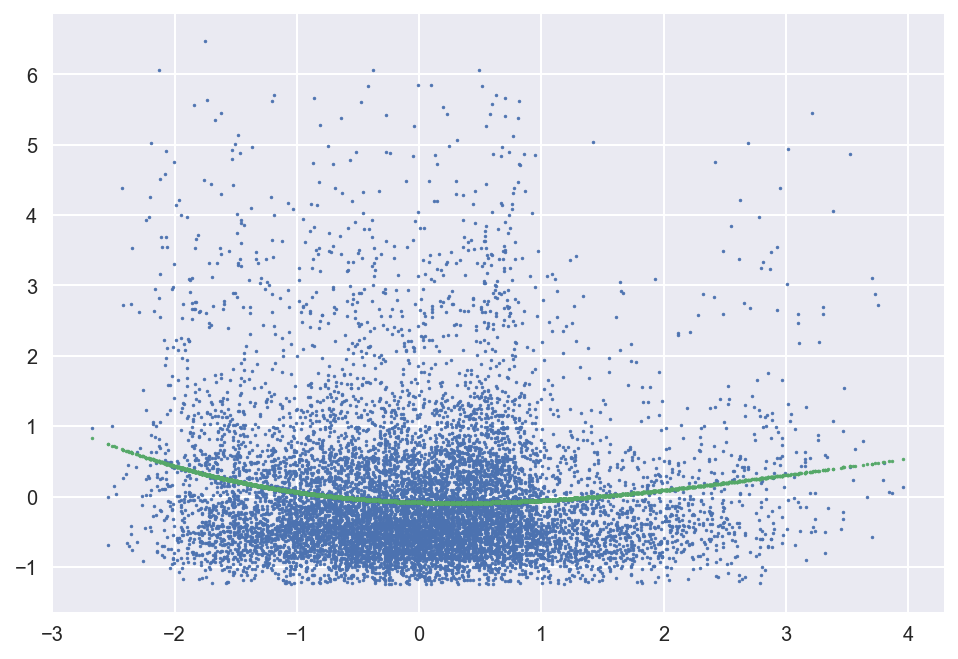

In [317]:
Y_pred = model.predict(X3_train)
plt.scatter(X_train, Y_train, s=scatter_pt_size)
plt.scatter(X_train, Y_pred, s=scatter_pt_size)
plt.show()